# Summary
In this notebook we embed names using RoBERTa. 

In [1]:
# experiments are going to be saved as follows:
# |- models
# |---- eperiment_1
# |---- | ---- tokenizer
# |---- | ---- model
# |---- | config.json
# ...
# 



# # Training config
# TRAIN_EPOCHS = 10
# LEARNING_RATE=0.0005
# WEIGHT_DECAY = 0.0001
# TRAIN_BATCH_SIZE = 512
# VALID_BATCH_SIZE = 128
# MAX_LEN=30
# mlm_probability=0.15

# # model config - RoBERTa
# vocab_size=5000
# max_position_embeddings=32
# num_attention_heads=4
# num_hidden_layers=2
# type_vocab_size=1


# Functions (into utils)

### Processing

In [2]:
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
    
class CustomDataset(Dataset):
    def __init__(self, text_list, tokenizer, max_len, include_attention_mask=True):
        """
        Custom Dataset for tokenized text.
        
        Args:
            text_list (list): List of input text strings.
            tokenizer (PreTrainedTokenizer): Hugging Face tokenizer instance.
            max_len (int): Maximum sequence length.
            include_attention_mask (bool): Whether to include attention masks.
        """
        self.examples = []
        self.include_attention_mask = include_attention_mask
        self.tokenizer = tokenizer

        # Preprocess the input text
        print("Preprocessing text into tokenized examples...")
        for example in tqdm(text_list, desc='Tokenizing text'):
            encoded = tokenizer(
                example,
                max_length=max_len,
                truncation=True,
                padding="max_length",
                return_attention_mask=include_attention_mask
            )
            self.examples.append(encoded)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        """
        Retrieve tokenized data at the specified index.
        Returns:
            Dictionary containing input IDs, attention masks (if applicable).
        """
        item = {"input_ids": torch.tensor(self.examples[index]["input_ids"], dtype=torch.long)}
        if self.include_attention_mask:
            item["attention_mask"] = torch.tensor(self.examples[index]["attention_mask"], dtype=torch.long)
        return item


### Tokenizer

In [3]:
import torch
import transformers

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from transformers import RobertaConfig, RobertaForMaskedLM, RobertaTokenizer, DebertaTokenizer, BertTokenizer
from tokenizers import ByteLevelBPETokenizer

# from datasets import load_metric, Dataset
from torch.utils.data import Dataset
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train a tokenizer
class BPE_Based_Tokenizer():
    def __init__(self, config):
        self.tokenizer      = ByteLevelBPETokenizer()
        self.vocab_size     = config.get("vocab_size")
        self.max_len        = config.get("max_len")
        self.min_frequency  = config.get("min_frequency")
        self.saving_path    = config.get("saving_path")
        self.model_type     = config.get("model_type")
        self.tokenizer_location = config.get("tokenizer_location")

        assert self.model_type in ['BERT', 'RoBERTa', 'DeBERTa'], "Model type must be in ['BERT', 'RoBERTa', 'DeBERTa']!"


    def train_and_save(self, training_names):
        self.tokenizer.train_from_iterator(
            training_names,
            vocab_size=self.vocab_size, min_frequency=self.min_frequency,
            show_progress=True,
            special_tokens=[
                "<s>",
                "<pad>",
                "</s>",
                "<unk>",
                "<mask>",
                ])
        self.tokenizer.save_model(self.tokenizer_location)

    def load_and_wrap_tokenizer(self):
        """
        A function that loads the tokenizer and also expand its functionality according to a model.
        This functionality allows it to do additional things, like `encode_plus`.
        """
        if self.model_type == 'BERT':
            self.tokenizer = BertTokenizer(vocab_file = self.tokenizer_location + '/vocab.json',
                                              merges_file= self.tokenizer_location + '/merges.txt')
            
        if self.model_type == 'RoBERTa':
            self.tokenizer = RobertaTokenizer(vocab_file = self.tokenizer_location + '/vocab.json',
                                              merges_file= self.tokenizer_location + '/merges.txt')
        
        if self.model_type == 'DeBERTa':
            self.tokenizer = DebertaTokenizer(vocab_file = self.tokenizer_location + '/vocab.json',
                                              merges_file= self.tokenizer_location + '/merges.txt')
        else:
            print("Didn't load any tokenizer")

    def encode_plus(self,x):
        return self.tokenizer.encode_plus(x,
                      max_length            = self.max_len,
                      # truncation=True,
                      add_special_tokens    = True,
                      pad_to_max_length     = True,
                      return_attention_mask = True,
                      return_tensors='pt')



/home/david/anaconda3/envs/demo_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [4]:
from transformers import BertConfig, BertForMaskedLM, RobertaConfig, RobertaForMaskedLM, DebertaV2Config, DebertaV2ForMaskedLM


def model_factory(model_config: dict):
    """
    Factory function to return a model ready for masked language modeling based on a custom configuration.

    Parameters:
        model_config: model config.

    Returns:
        model: The initialized model configured for masked language modeling.
    """

    model_type = model_config.get('model_type')

    if model_type == "BERT":
        config = BertConfig(**model_config)
        model = BertForMaskedLM(config=config)
    elif model_type == "RoBERTa":
        config = RobertaConfig(**model_config)
        model = RobertaForMaskedLM(config=config)
    elif model_type == "DeBERTa":
        config = DebertaV2Config(**model_config)
        model = DebertaV2ForMaskedLM(config=config)
    else:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from ['BERT', 'RoBERTa', 'DeBERTa'].")

    return model

### Experiment

In [5]:
import logging
import matplotlib.pyplot as plt
import os
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from transformers import TrainerCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, logger):
        super().__init__()
        self.logger = logger

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            for key, value in logs.items():
                self.logger.info(f"{key}: {value}")


# utils
def initiate_new_experiment(model_folder):
    """
    This function checks which is the most up-to-date experiment and initiates a new folder.
    In the new folder, it initiates the relevant folders and saves the config in text.
    """
    num_current_experiments = len(os.listdir(model_folder))
    new_experiment_index = num_current_experiments + 1
    new_experiment_location = os.path.join(model_folder, f'experiment_{new_experiment_index}')
    os.mkdir(new_experiment_location)
    return new_experiment_location, new_experiment_index

def setup_logger(log_folder):
    """
    Sets up the logger to save logs to the specified log folder.
    """
    os.makedirs(log_folder, exist_ok=True)
    log_file = os.path.join(log_folder, "experiment.log")
    logging.basicConfig(
        filename=log_file,
        filemode="w",
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logger = logging.getLogger()
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
    logger.addHandler(console_handler)
    return logger


def experiment(general_config, tokenizer_config, model_config, train_config):
    
    # -------------------
    # Setup
    # -------------------
    # load data
    with open(general_config.get("training_set_path"), "r") as file:
        training_names_txt = [line.strip() for line in file]
    with open(general_config.get("validation_set_path"), "r") as file:
        validation_names_txt = [line.strip() for line in file]

    # training_names_txt = training_names_txt[:10_000]
    # validation_names_txt = validation_names_txt[:1500]

    # create a new experiment folder
    experiment_location, experiment_index = initiate_new_experiment(general_config.get('experiments_folder'))
    log_folder = os.path.join("logs", "training_logs", f"experiment_{experiment_index}")
    print(f'Saving log to {log_folder}')
    logger = setup_logger(log_folder)
    logging_callback = LoggingCallback(logger)

    logger.info("Starting experiment %d", experiment_index)
    logger.info("Experiment location: %s", experiment_location)

    # initiate a tokenizer
    logger.info("Setting up the tokenizer")
    tokenizer_obj = BPE_Based_Tokenizer(tokenizer_config)

    if tokenizer_config['create_a_new_tokenizer']:
        tokenizer_config['tokenizer_location'] = experiment_location + '/tokenizer'
        os.mkdir(experiment_location+'/tokenizer')
        # train the tokenizer, wrap it with HF tokenizer
        logger.info("Training new tokenizer")
        tokenizer_obj.train_and_save(training_names_txt)
    else:
        assert "tokenizer_location" in tokenizer_config.keys(), 'If a tokenizer is loaded, a location must be provided'
        logger.info("Loading tokenizer from %s", tokenizer_config['tokenizer_location'])

    # load BERT-type tokenizer
    tokenizer_obj.load_and_wrap_tokenizer()

    # initiate a model
    logger.info("Initializing the model")
    model = model_factory(model_config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # -------------------
    # data processing
    # -------------------
    logger.info("Preparing datasets")
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer_obj.tokenizer, mlm=True, mlm_probability=0.15
    )
    
    train_dataset = CustomDataset(
        text_list=training_names_txt,
        tokenizer=tokenizer_obj.tokenizer,
        max_len=tokenizer_config['max_len'],
        include_attention_mask=True
    )
    eval_dataset = CustomDataset(
        text_list=validation_names_txt,
        tokenizer=tokenizer_obj.tokenizer,
        max_len=tokenizer_config['max_len'], 
        include_attention_mask=True
    )
    
    # -------------------
    # Training
    # -------------------
    logger.info("Starting training")
    training_args = TrainingArguments(
        output_dir="model_folder",
        overwrite_output_dir=True,
        eval_strategy='epoch',
        num_train_epochs=train_config["train_epochs"],
        learning_rate=train_config["learning_rate"],
        weight_decay=train_config["weight_decay"],
        per_device_train_batch_size=train_config["train_batch_size"],
        per_device_eval_batch_size=train_config["valid_batch_size"],
        save_steps=train_config['save_steps'],
        eval_steps=train_config['eval_steps'],
        save_total_limit=1,
        max_grad_norm=1.0,
        logging_steps = 20,
        logging_dir=log_folder
    )

    # Create the trainer for our model
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[logging_callback]
    )

    # Train the model
    trainer.train()

    # Save model
    logger.info("Training complete. Saving model.")
    os.mkdir(experiment_location+'/model')
    model.save_pretrained(experiment_location+'/model')

    # -----------------------
    # post modeling
    # -----------------------
    log_history = trainer.state.log_history
    training_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
    eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

    # Plot training and validation losses
    plt.plot(training_losses, label="Training Loss")
    plt.plot(eval_losses, label="Validation Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Training")
    plt.savefig(f"{log_folder}/loss_plot.png", format="png", dpi=300)

    return trainer, model, eval_dataset

import os
# os.chdir('../')
os.chdir('/home/david/Desktop/projects/NameEmbedding/')

general_config = {
    'model_type':'RoBERTa',
    'experiments_folder':'./experiments',
    'training_set_path':"./data/raw/text/training_names_processed.txt",
    'validation_set_path':"./data/raw/text/validation_names_processed.txt",
}
tokenizer_config = {
    'model_type':general_config['model_type'],
    'vocab_size' : 5000,
    'min_frequency' : 2,
    'max_len':30,
    'add_special_tokens' : True,
    'pad_to_max_length' : True,
    'return_attention_mask' : True,
    'return_tensors' : 'pt',
    'create_a_new_tokenizer': True,
    'tokenizer_location':'./experiments/experiment_1/tokenizer'
}

model_config = {
    'model_type':general_config['model_type'],
    "vocab_size": tokenizer_config['vocab_size'],
    "max_position_embeddings": 32,
    "num_attention_heads": 4,
    "num_hidden_layers": 2,
    "type_vocab_size": 1,
}

# Training config
train_config = {
    "train_epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "train_batch_size": 512,
    "valid_batch_size": 32,
    "max_len": 30,
    "mlm_probability": 0.15,
    'save_steps':50,
    'eval_steps':50,
}


trainer, model, eval_dataset = experiment(general_config, tokenizer_config, model_config, train_config)

2024-12-21 21:10:29,752 - INFO - Starting experiment 1
2024-12-21 21:10:29,753 - INFO - Experiment location: ./experiments/experiment_1
2024-12-21 21:10:29,753 - INFO - Setting up the tokenizer
2024-12-21 21:10:29,754 - INFO - Training new tokenizer


Saving log to logs/training_logs/experiment_1





/home/david/anaconda3/envs/demo_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-12-21 21:11:14,603 - INFO - Initializing the model


Didn't load any tokenizer


2024-12-21 21:11:14,878 - INFO - Preparing datasets


Preprocessing text into tokenized examples...


Tokenizing text: 100%|██████████| 7892459/7892459 [08:23<00:00, 15667.96it/s]


Preprocessing text into tokenized examples...


Tokenizing text: 100%|██████████| 961726/961726 [01:01<00:00, 15653.75it/s]
2024-12-21 21:20:40,052 - INFO - Starting training


Epoch,Training Loss,Validation Loss


2024-12-21 21:20:55,499 - INFO - loss: 7.1905
2024-12-21 21:20:55,500 - INFO - grad_norm: 10.024648666381836
2024-12-21 21:20:55,501 - INFO - learning_rate: 0.0009998702562439182
2024-12-21 21:20:55,501 - INFO - epoch: 0.0012974375608173856
2024-12-21 21:20:55,500 - INFO - grad_norm: 10.024648666381836
2024-12-21 21:20:55,501 - INFO - learning_rate: 0.0009998702562439182
2024-12-21 21:20:55,501 - INFO - epoch: 0.0012974375608173856
2024-12-21 21:20:59,554 - INFO - loss: 5.9562
2024-12-21 21:20:59,555 - INFO - grad_norm: 1.6802603006362915
2024-12-21 21:20:59,555 - INFO - learning_rate: 0.0009997405124878365
2024-12-21 21:20:59,556 - INFO - epoch: 0.0025948751216347712
2024-12-21 21:20:59,554 - INFO - loss: 5.9562
2024-12-21 21:20:59,555 - INFO - grad_norm: 1.6802603006362915
2024-12-21 21:20:59,555 - INFO - learning_rate: 0.0009997405124878365
2024-12-21 21:20:59,556 - INFO - epoch: 0.0025948751216347712
2024-12-21 21:21:04,421 - INFO - loss: 5.7031
2024-12-21 21:21:04,421 - INFO - gra

In [ ]:
print('done')

done


In [7]:
import numpy as np
with torch.no_grad():
  predictions = []
  for j in tqdm(range(1000)): # len(eval_dataset)
    pred = model.base_model(eval_dataset[j]['input_ids'].unsqueeze(0).to(device)).last_hidden_state[0,0,:].detach().cpu().numpy()
    predictions.append(pred)
predictions = np.array(predictions)

100%|██████████| 1000/1000 [00:01<00:00, 801.35it/s]


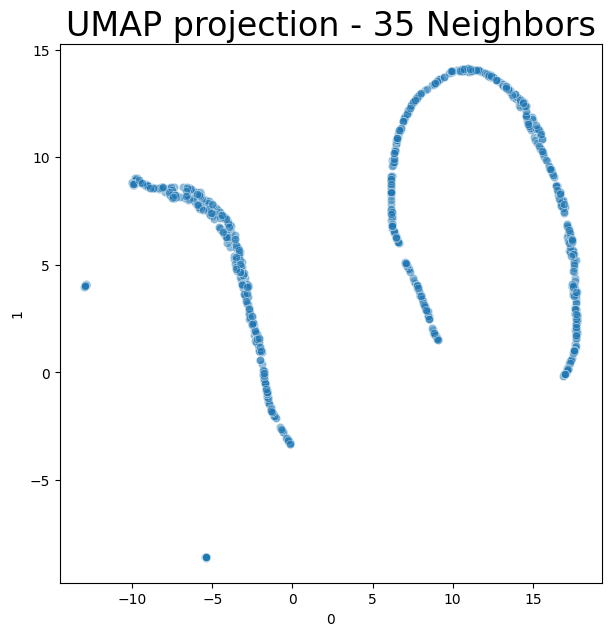

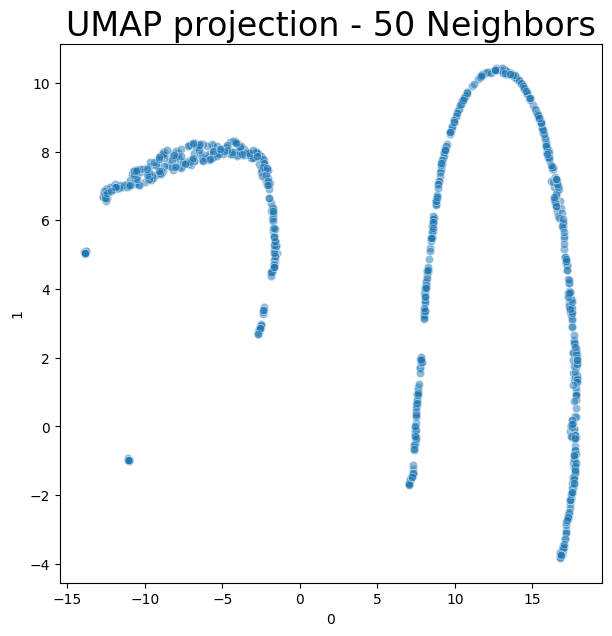

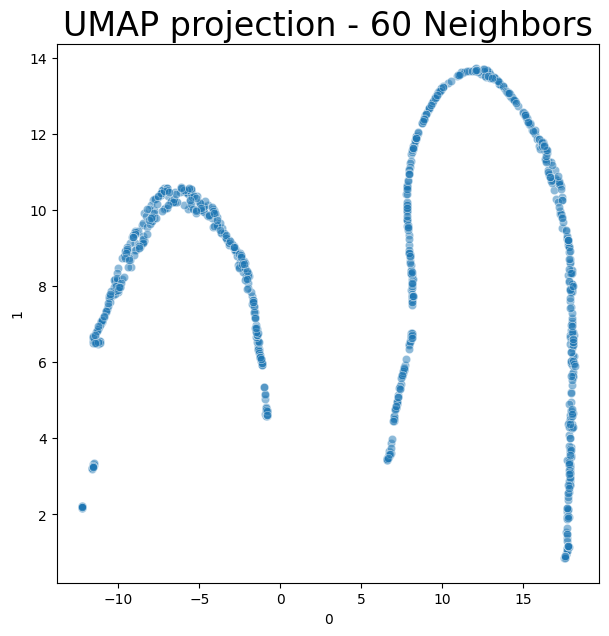

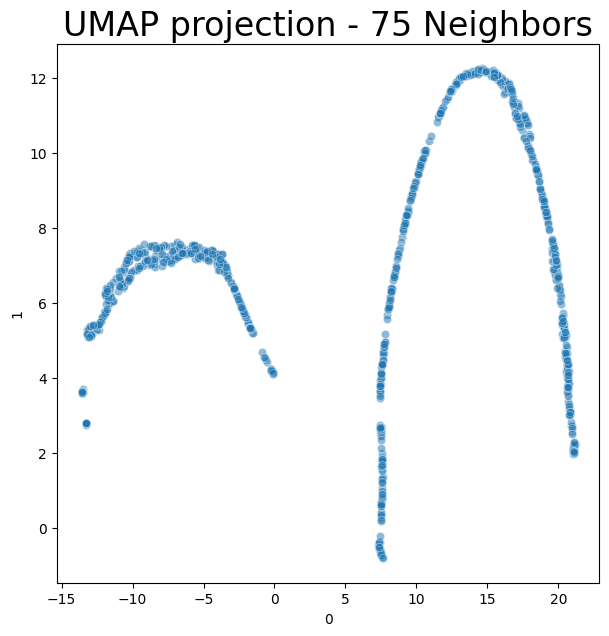

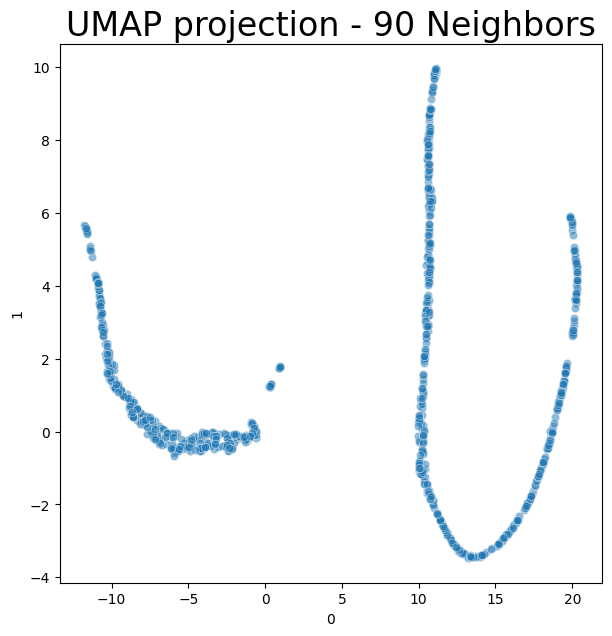

In [10]:
import umap
import seaborn as sns
import pandas as pd

for neigh in [35,50,60,75,90]:

  reducer = umap.UMAP(n_neighbors = neigh)
  embedding = reducer.fit_transform(predictions)
  # print('Embedding Mat shape', embedding.shape)
  embedding_pd = pd.DataFrame(embedding)
  embedding_pd.iloc[:5]

  # plot
  plt.figure(figsize=(7,7))
  sns.scatterplot(data = embedding_pd, x=0, y=1, alpha = 0.5) #, hue = 'label')
  plt.title(f'UMAP projection - {neigh} Neighbors', fontsize=24)
  plt.show()
